In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from utils import load_dat_file


# Meine Dataset Klasse
class GasSensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self, model_dim, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, model_dim)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2).float() * (-np.log(10000.0) / model_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        # x: (batch_size, seq_len, model_dim)
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

In [15]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, model_dim=64, n_heads=4, num_layers=2, dim_feedforward=128, lr=0.001):
        super(TimeSeriesTransformer, self).__init__()
        self.model_dim = model_dim

        # Pos Encoding
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim)

        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Klassifikation
        self.classifier = nn.Linear(model_dim, num_classes)

        # Loss und Optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1) # Macht eine global avg Pooling über Sequenz
        out = self.classifier(x)
        return out
    
    def train_step(self, batch):
        self.optimizer.zero_grad()
        X_batch, y_batch = batch
        device = next(self.parameters()).device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def train_model(self, train_loader, epochs):
        all_losses = []
        for epoch in range(epochs):
            total_loss = 0
            for batch in train_loader:
                loss = self.train_step(batch)
                total_loss += loss
            avg_loss = total_loss / len(train_loader)
            all_losses.append(avg_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
        # Neu: Plotte die Losse danach
        plt.figure(figsize=(8,5))
        plt.plot(range(1, epochs+1), all_losses, marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Average Training Loss")
        plt.title("LSTM Training Loss")
        plt.grid(True)
        plt.show()
        return all_losses

    def evaluate(self, test_loader):
        self.eval()
        correct, total = 0, 0
        device = next(self.parameters()).device
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = self(X_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        accuracy = correct / total
        print(f"Test Accuracy: {accuracy:.4f}")
        self.train()
        return accuracy

    def save(self, path):
        torch.save(self.state_dict(), path)
        print(f"Model saved to {path}")

    def load(self, path):
        self.load_state_dict(torch.load(path, map_location=map_location))
        print(f"Model loaded from {path}")

In [16]:
# Datenvorbereitung

# Batch1.dat erstmal
file = r"gas+sensor+array+drift+dataset\Dataset\batch1.dat"
df = load_dat_file(file)

X = df.iloc[:, 0:128].values
y = df.iloc[:, 128].values

scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


SEQ_LEN = 50

def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len + 1):
       xs.append(X[i:i+seq_len])
       ys.append(y[i+seq_len-1] - 1)
    return np.array(xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, SEQ_LEN)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, SEQ_LEN)

train_dataset = GasSensorDataset(X_train_seq, y_train_seq)
test_dataset = GasSensorDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Using device: cpu
Epoch [1/30], Loss: 1.8073
Epoch [2/30], Loss: 1.7590
Epoch [3/30], Loss: 1.7649
Epoch [4/30], Loss: 1.7315
Epoch [5/30], Loss: 1.7461
Epoch [6/30], Loss: 1.7345
Epoch [7/30], Loss: 1.7374
Epoch [8/30], Loss: 1.7327
Epoch [9/30], Loss: 1.7284
Epoch [10/30], Loss: 1.7236
Epoch [11/30], Loss: 1.7173
Epoch [12/30], Loss: 1.6979
Epoch [13/30], Loss: 1.6730
Epoch [14/30], Loss: 1.6342
Epoch [15/30], Loss: 1.5387
Epoch [16/30], Loss: 1.4160
Epoch [17/30], Loss: 1.1820
Epoch [18/30], Loss: 0.9316
Epoch [19/30], Loss: 0.6813
Epoch [20/30], Loss: 0.5545
Epoch [21/30], Loss: 0.4440
Epoch [22/30], Loss: 0.4513
Epoch [23/30], Loss: 0.4659
Epoch [24/30], Loss: 0.3879
Epoch [25/30], Loss: 0.3424
Epoch [26/30], Loss: 0.2793
Epoch [27/30], Loss: 0.2703
Epoch [28/30], Loss: 0.2374
Epoch [29/30], Loss: 0.2398
Epoch [30/30], Loss: 0.2561


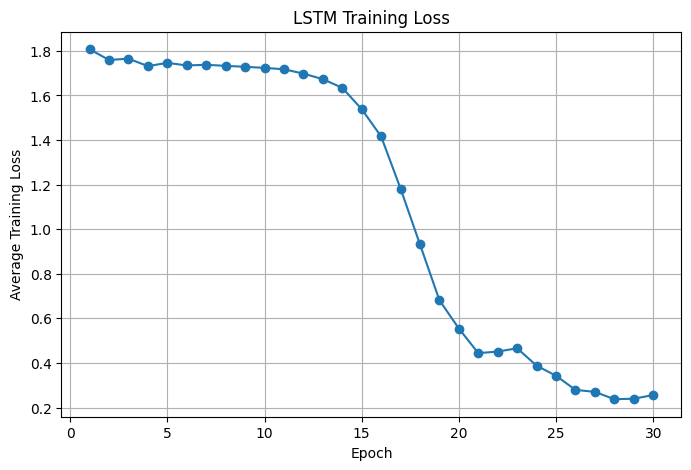

Test Accuracy: 0.9250
Test Accuracy: 0.9250
True: Methane, Predicted: Methane
True: Ammonia, Predicted: Ammonia
True: Toluene, Predicted: Toluene
True: Methane, Predicted: Methane
True: Ammonia, Predicted: Ammonia
True: Benzene, Predicted: Benzene
True: Acetone, Predicted: Acetone
True: Methane, Predicted: Methane
True: Ammonia, Predicted: Ammonia
True: Toluene, Predicted: Ethylene
True: Acetone, Predicted: Acetone
True: Methane, Predicted: Methane
True: Ammonia, Predicted: Ammonia
True: Toluene, Predicted: Toluene
True: Benzene, Predicted: Benzene
True: Methane, Predicted: Methane
True: Ethylene, Predicted: Methane
True: Benzene, Predicted: Benzene
True: Acetone, Predicted: Acetone
True: Acetone, Predicted: Acetone
Model saved to transformer_batch1.pth


In [17]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = TimeSeriesTransformer(input_dim=128, num_classes=6, model_dim=64, n_heads=4, num_layers=2)
model.to(device)

model.train_model(train_loader, epochs=30)

model.evaluate(test_loader)


# Vorhersage der Gasarten-Namen
gas_labels = ["Ammonia", "Acetone", "Benzene", "Ethylene", "Methane", "Toluene"]

model.eval()

all_preds = [] # Vorhersagen
all_labels = [] # Echte Labels

with torch.no_grad(): # Schalte Gradient Tracking aus
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Accuracy berechnen
correct = sum(p == t for p, t in zip(all_preds, all_labels))
accuracy = correct / len(all_labels)
print(f"Test Accuracy: {accuracy:.4f}")

for true_idx, pred_idx in zip(all_labels[:20], all_preds[:20]):
    print(f"True: {gas_labels[true_idx]}, Predicted: {gas_labels[pred_idx]}")


model.save("transformer_batch1.pth")


--- Fold 1/5 ---
Epoch [1/30], Loss: 1.6006
Epoch [2/30], Loss: 1.2055
Epoch [3/30], Loss: 0.9673
Epoch [4/30], Loss: 0.8083
Epoch [5/30], Loss: 0.6875
Epoch [6/30], Loss: 0.5934
Epoch [7/30], Loss: 0.5313
Epoch [8/30], Loss: 0.4728
Epoch [9/30], Loss: 0.4048
Epoch [10/30], Loss: 0.3491
Epoch [11/30], Loss: 0.3169
Epoch [12/30], Loss: 0.2774
Epoch [13/30], Loss: 0.2296
Epoch [14/30], Loss: 0.2101
Epoch [15/30], Loss: 0.1699
Epoch [16/30], Loss: 0.1431
Epoch [17/30], Loss: 0.1258
Epoch [18/30], Loss: 0.1143
Epoch [19/30], Loss: 0.1008
Epoch [20/30], Loss: 0.0953
Epoch [21/30], Loss: 0.0689
Epoch [22/30], Loss: 0.0652
Epoch [23/30], Loss: 0.0597
Epoch [24/30], Loss: 0.0489
Epoch [25/30], Loss: 0.0427
Epoch [26/30], Loss: 0.0405
Epoch [27/30], Loss: 0.0378
Epoch [28/30], Loss: 0.0503
Epoch [29/30], Loss: 0.0925
Epoch [30/30], Loss: 0.0605


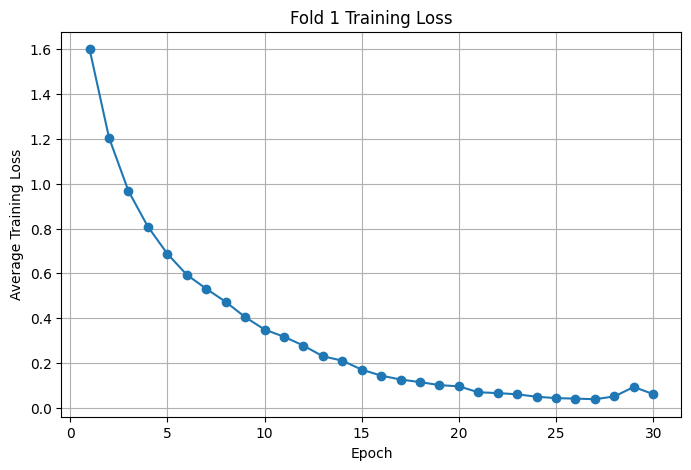

Test Accuracy: 1.0000

--- Fold 2/5 ---
Epoch [1/30], Loss: 1.7401
Epoch [2/30], Loss: 1.4722
Epoch [3/30], Loss: 1.1456
Epoch [4/30], Loss: 0.9356
Epoch [5/30], Loss: 0.8029
Epoch [6/30], Loss: 0.6804
Epoch [7/30], Loss: 0.5843
Epoch [8/30], Loss: 0.5058
Epoch [9/30], Loss: 0.4077
Epoch [10/30], Loss: 0.3705
Epoch [11/30], Loss: 0.3132
Epoch [12/30], Loss: 0.2763
Epoch [13/30], Loss: 0.2503
Epoch [14/30], Loss: 0.2477
Epoch [15/30], Loss: 0.2055
Epoch [16/30], Loss: 0.1733
Epoch [17/30], Loss: 0.1292
Epoch [18/30], Loss: 0.1168
Epoch [19/30], Loss: 0.1000
Epoch [20/30], Loss: 0.0893
Epoch [21/30], Loss: 0.0840
Epoch [22/30], Loss: 0.0744
Epoch [23/30], Loss: 0.0763
Epoch [24/30], Loss: 0.0795
Epoch [25/30], Loss: 0.0710
Epoch [26/30], Loss: 0.0569
Epoch [27/30], Loss: 0.0508
Epoch [28/30], Loss: 0.0466
Epoch [29/30], Loss: 0.0431
Epoch [30/30], Loss: 0.0392


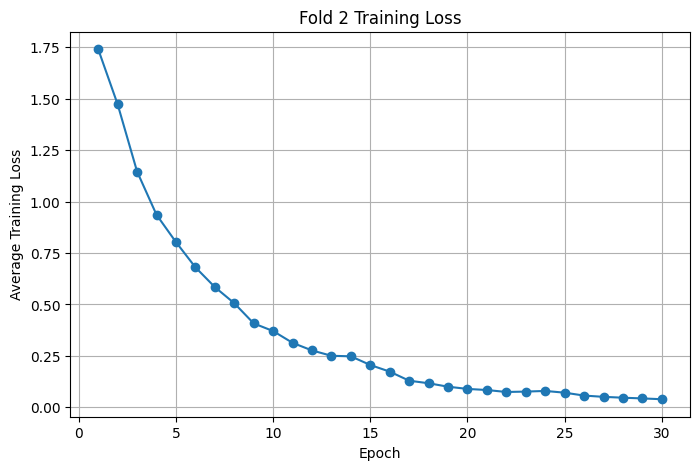

Test Accuracy: 1.0000

--- Fold 3/5 ---
Epoch [1/30], Loss: 1.6704
Epoch [2/30], Loss: 1.3372
Epoch [3/30], Loss: 0.9915
Epoch [4/30], Loss: 0.7906
Epoch [5/30], Loss: 0.6856
Epoch [6/30], Loss: 0.5643
Epoch [7/30], Loss: 0.4618
Epoch [8/30], Loss: 0.3964
Epoch [9/30], Loss: 0.3594
Epoch [10/30], Loss: 0.2768
Epoch [11/30], Loss: 0.2455
Epoch [12/30], Loss: 0.1972
Epoch [13/30], Loss: 0.1592
Epoch [14/30], Loss: 0.1407
Epoch [15/30], Loss: 0.1189
Epoch [16/30], Loss: 0.1092
Epoch [17/30], Loss: 0.0907
Epoch [18/30], Loss: 0.0759
Epoch [19/30], Loss: 0.0633
Epoch [20/30], Loss: 0.0557
Epoch [21/30], Loss: 0.0533
Epoch [22/30], Loss: 0.0576
Epoch [23/30], Loss: 0.0972
Epoch [24/30], Loss: 0.0737
Epoch [25/30], Loss: 0.0712
Epoch [26/30], Loss: 0.0438
Epoch [27/30], Loss: 0.0526
Epoch [28/30], Loss: 0.0322
Epoch [29/30], Loss: 0.0367
Epoch [30/30], Loss: 0.0246


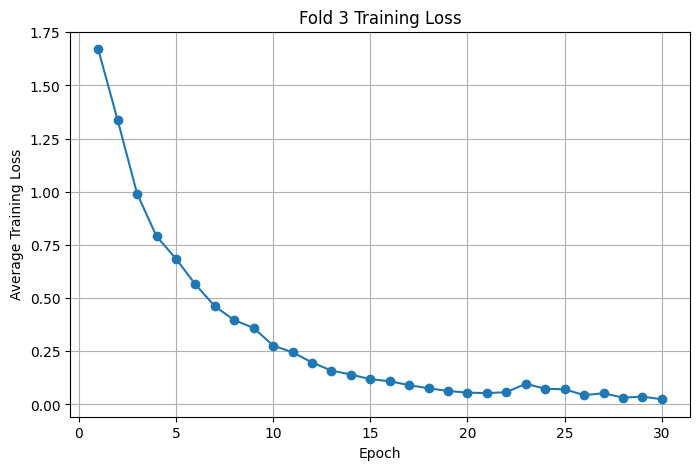

Test Accuracy: 0.9620

--- Fold 4/5 ---
Epoch [1/30], Loss: 1.5715
Epoch [2/30], Loss: 1.1591
Epoch [3/30], Loss: 0.9411
Epoch [4/30], Loss: 0.7907
Epoch [5/30], Loss: 0.6753
Epoch [6/30], Loss: 0.6045
Epoch [7/30], Loss: 0.5032
Epoch [8/30], Loss: 0.4131
Epoch [9/30], Loss: 0.3476
Epoch [10/30], Loss: 0.3025
Epoch [11/30], Loss: 0.2707
Epoch [12/30], Loss: 0.2376
Epoch [13/30], Loss: 0.2026
Epoch [14/30], Loss: 0.1671
Epoch [15/30], Loss: 0.1533
Epoch [16/30], Loss: 0.1365
Epoch [17/30], Loss: 0.1264
Epoch [18/30], Loss: 0.1007
Epoch [19/30], Loss: 0.0864
Epoch [20/30], Loss: 0.0858
Epoch [21/30], Loss: 0.0739
Epoch [22/30], Loss: 0.0963
Epoch [23/30], Loss: 0.0976
Epoch [24/30], Loss: 0.0559
Epoch [25/30], Loss: 0.0501
Epoch [26/30], Loss: 0.0532
Epoch [27/30], Loss: 0.0501
Epoch [28/30], Loss: 0.0509
Epoch [29/30], Loss: 0.0444
Epoch [30/30], Loss: 0.0232


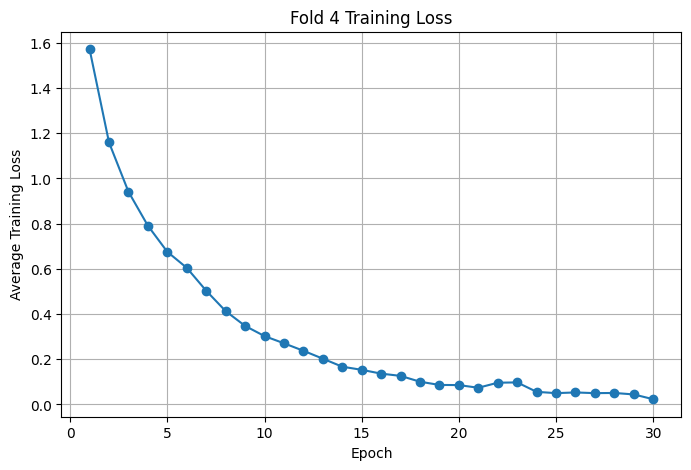

Test Accuracy: 0.9747

--- Fold 5/5 ---
Epoch [1/30], Loss: 1.6471
Epoch [2/30], Loss: 1.3097
Epoch [3/30], Loss: 0.9985
Epoch [4/30], Loss: 0.7923
Epoch [5/30], Loss: 0.6623
Epoch [6/30], Loss: 0.5490
Epoch [7/30], Loss: 0.4646
Epoch [8/30], Loss: 0.3894
Epoch [9/30], Loss: 0.3323
Epoch [10/30], Loss: 0.2958
Epoch [11/30], Loss: 0.2488
Epoch [12/30], Loss: 0.2041
Epoch [13/30], Loss: 0.2301
Epoch [14/30], Loss: 0.1795
Epoch [15/30], Loss: 0.1491
Epoch [16/30], Loss: 0.1180
Epoch [17/30], Loss: 0.0977
Epoch [18/30], Loss: 0.0917
Epoch [19/30], Loss: 0.0762
Epoch [20/30], Loss: 0.0720
Epoch [21/30], Loss: 0.0602
Epoch [22/30], Loss: 0.0465
Epoch [23/30], Loss: 0.0381
Epoch [24/30], Loss: 0.0316
Epoch [25/30], Loss: 0.0282
Epoch [26/30], Loss: 0.0233
Epoch [27/30], Loss: 0.0240
Epoch [28/30], Loss: 0.0208
Epoch [29/30], Loss: 0.0203
Epoch [30/30], Loss: 0.0198


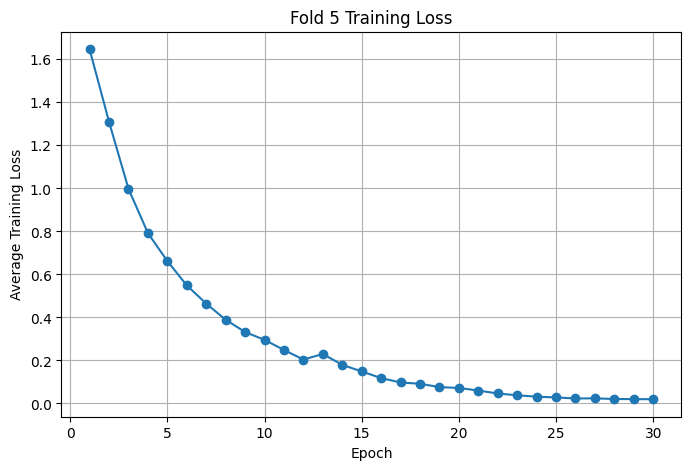

Test Accuracy: 0.9873

Average Accuracy across 5 folds: 0.9848


In [18]:
# NEU: 5-Fold Cross Validation

EPOCHS = 30

# Sequenzen einmal erstellen
X_seq, y_seq = create_sequences(X, y, SEQ_LEN)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_seq)):
    print(f"\n--- Fold {fold+1}/5 ---")
    
    # Fold-Daten
    X_train_fold, y_train_fold = X_seq[train_idx], y_seq[train_idx]
    X_val_fold, y_val_fold = X_seq[val_idx], y_seq[val_idx]
    
    train_dataset = GasSensorDataset(X_train_fold, y_train_fold)
    val_dataset = GasSensorDataset(X_val_fold, y_val_fold)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    
    # Neues Modell pro Fold
    model = TimeSeriesTransformer(input_dim=128, num_classes=6,
                                  model_dim=64, n_heads=4,
                                  num_layers=2, lr=0.001)
    model.to(device)
    
    # Training + Loss speichern
    all_losses = []
    for epoch in range(EPOCHS):
        total_loss = 0
        for batch in train_loader:
            loss = model.train_step(batch)
            total_loss += loss
        avg_loss = total_loss / len(train_loader)
        all_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}")
    
    # Loss-Kurve plotten
    plt.figure(figsize=(8,5))
    plt.plot(range(1, EPOCHS+1), all_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Average Training Loss")
    plt.title(f"Fold {fold+1} Training Loss")
    plt.grid(True)
    plt.show()
    
    # Evaluation 
    acc = model.evaluate(val_loader)
    fold_accuracies.append(acc)

# Durchschnittliche Accuracy der folds
avg_acc = np.mean(fold_accuracies)
print(f"\nAverage Accuracy across 5 folds: {avg_acc:.4f}")